<a href="https://colab.research.google.com/github/WenyiYao/cryptocurrency/blob/main/transformer_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras_nlp
from keras.layers import TimeDistributed
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os
import pandas as pd
import numpy as np

In [56]:
df = pd.read_json('poolDayData_0.json')
df.head()

,id,high,low,tvlUSD,txCount,volumeUSD,date,open,tick,close
0,0x07a6e955ba4345bae83ac2a6faa771fddd8a2011-19251,0.787862,0.829892,390558.121780,63,47603.628095,2022-09-16,0.825782,-278530,0.807040
1,0x07a6e955ba4345bae83ac2a6faa771fddd8a2011-19252,0.796931,0.829426,391985.894464,43,25969.275749,2022-09-17,0.807040,-278202,0.824302
2,0x07a6e955ba4345bae83ac2a6faa771fddd8a2011-19253,0.756814,0.829987,374113.451267,64,39271.628388,2022-09-18,0.824302,-279093,0.750910
3,0x07a6e955ba4345bae83ac2a6faa771fddd8a2011-19254,0.727532,0.778021,377515.557429,97,74419.312606,2022-09-19,0.750910,-278972,0.765373
4,0x07a6e955ba4345bae83ac2a6faa771fddd8a2011-19255,0.722816,0.765373,369165.264073,56,45400.579439,2022-09-20,0.765373,-279395,0.735607


In [57]:
df = df.drop(columns=["id"])
df = df.set_index(['date'])
df.head()

,high,low,tvlUSD,txCount,volumeUSD,open,tick,close
date,,,,,,,,
2022-09-16,0.787862,0.829892,390558.121780,63,47603.628095,0.825782,-278530,0.807040
2022-09-17,0.796931,0.829426,391985.894464,43,25969.275749,0.807040,-278202,0.824302
2022-09-18,0.756814,0.829987,374113.451267,64,39271.628388,0.824302,-279093,0.750910
2022-09-19,0.727532,0.778021,377515.557429,97,74419.312606,0.750910,-278972,0.765373
2022-09-20,0.722816,0.765373,369165.264073,56,45400.579439,0.765373,-279395,0.735607


In [58]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=df.index,
                                     open=df['open'],
                                     high=df['high'],
                                     low=df['low'],
                                     close=df['close'])])
fig.show()

In [59]:
dataset = df.values
dataset

array([[ 7.87862287e-01,  8.29892477e-01,  3.90558122e+05, ...,
         8.25781924e-01, -2.78530000e+05,  8.07040060e-01],
       [ 7.96930701e-01,  8.29426013e-01,  3.91985894e+05, ...,
         8.07040060e-01, -2.78202000e+05,  8.24302185e-01],
       [ 7.56813753e-01,  8.29986952e-01,  3.74113451e+05, ...,
         8.24302185e-01, -2.79093000e+05,  7.50909829e-01],
       ...,
       [ 6.87838526e-01,  7.38167099e-01,  3.59513332e+05, ...,
         6.94514893e-01, -2.79577000e+05,  7.25942301e-01],
       [ 7.10644868e-01,  7.43249712e-01,  3.59720647e+05, ...,
         7.25942301e-01, -2.79292000e+05,  7.60861060e-01],
       [ 6.62648431e-01,  8.23300917e-01,  3.75465258e+05, ...,
         7.60861060e-01, -2.78565000e+05,  0.00000000e+00]])

In [60]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [61]:
def create_sequence(dataset, sequence_length=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-sequence_length-1):
        a = dataset[i:(i+sequence_length)]
        dataX.append(a)
        dataY.append(dataset[i+sequence_length,[0,1,7]]) #predict high, low, and close
    return numpy.array(dataX), numpy.array(dataY)

In [62]:
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [63]:
sequence_length = 4
trainX, trainY = create_sequence(train, sequence_length)
testX, testY = create_sequence(test, sequence_length)

In [64]:
print(trainX.shape)
print(trainY.shape)

(288, 4, 8)
(288, 3)


In [65]:
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

In [66]:
batch_size = 8
epochs=25

model1 = keras.Sequential([
    layers.Input(shape=(sequence_length, 8)),
    keras_nlp.layers.TransformerEncoder(num_heads=2, intermediate_dim=32),
    layers.GlobalAveragePooling1D(),
    layers.Dense(3) # output layer with 3 units for close, high and open value
])

model1.compile(loss='mean_squared_error', optimizer='adam')

history = model1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=2, shuffle=False)

Epoch 1/25
33/33 - 3s - loss: 1.6142 - val_loss: 0.8793 - 3s/epoch - 91ms/step
Epoch 2/25
33/33 - 0s - loss: 0.0787 - val_loss: 0.7340 - 120ms/epoch - 4ms/step
Epoch 3/25
33/33 - 0s - loss: 0.0415 - val_loss: 0.5332 - 136ms/epoch - 4ms/step
Epoch 4/25
33/33 - 0s - loss: 0.0361 - val_loss: 0.4147 - 130ms/epoch - 4ms/step
Epoch 5/25
33/33 - 0s - loss: 0.0320 - val_loss: 0.3457 - 113ms/epoch - 3ms/step
Epoch 6/25
33/33 - 0s - loss: 0.0290 - val_loss: 0.3068 - 117ms/epoch - 4ms/step
Epoch 7/25
33/33 - 0s - loss: 0.0266 - val_loss: 0.2882 - 126ms/epoch - 4ms/step
Epoch 8/25
33/33 - 0s - loss: 0.0247 - val_loss: 0.2792 - 119ms/epoch - 4ms/step
Epoch 9/25
33/33 - 0s - loss: 0.0231 - val_loss: 0.2742 - 114ms/epoch - 3ms/step
Epoch 10/25
33/33 - 0s - loss: 0.0217 - val_loss: 0.2679 - 115ms/epoch - 3ms/step
Epoch 11/25
33/33 - 0s - loss: 0.0205 - val_loss: 0.2598 - 135ms/epoch - 4ms/step
Epoch 12/25
33/33 - 0s - loss: 0.0194 - val_loss: 0.2515 - 125ms/epoch - 4ms/step
Epoch 13/25
33/33 - 0s - lo

In [67]:
model1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_encoder_8 (Tra  (None, 4, 8)              872       
 nsformerEncoder)                                                
                                                                 
 global_average_pooling1d_8  (None, 8)                 0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_6 (Dense)             (None, 3)                 27        
                                                                 
Total params: 899 (3.51 KB)
Trainable params: 899 (3.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


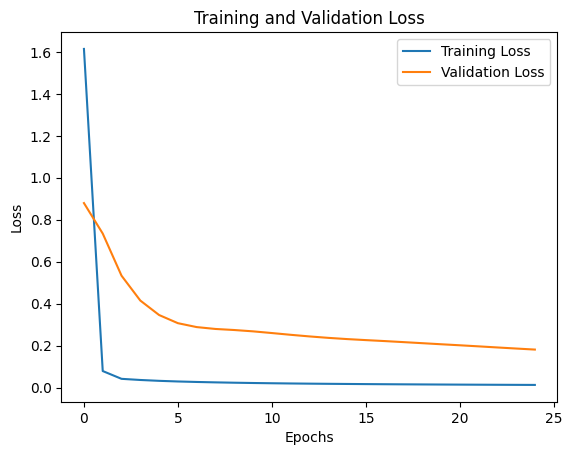

In [68]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [69]:
trainPredict = model1.predict(trainX, batch_size=batch_size)
trainScore = math.sqrt(mean_squared_error(trainY[:, 0], trainPredict[:, 0]))
print('Train Score of high value: %.10f RMSE' % (trainScore))
trainScore = math.sqrt(mean_squared_error(trainY[:, 1], trainPredict[:, 1]))
print('Train Score of low value: %.10f RMSE' % (trainScore))
trainScore = math.sqrt(mean_squared_error(trainY[:, 2], trainPredict[:, 2]))
print('Train Score of close value: %.10f RMSE' % (trainScore))

36/36 [==============================] - 0s 2ms/step
Train Score of high value: 0.1187548891 RMSE
Train Score of low value: 0.1622188677 RMSE
Train Score of close value: 0.2052338253 RMSE


In [70]:
testPredict = model1.predict(testX, batch_size=batch_size)
testScore = math.sqrt(mean_squared_error(testY[:, 0], testPredict[:, 0]))
print('Test Score of high value: %.2f RMSE' % (testScore))
trainScore = math.sqrt(mean_squared_error(testY[:, 1], testPredict[:, 1]))
print('Test Score of low value: %.10f RMSE' % (trainScore))
trainScore = math.sqrt(mean_squared_error(testY[:, 2], testPredict[:, 2]))
print('Test Score of close value: %.10f RMSE' % (trainScore))

16/16 [==============================] - 0s 2ms/step
Test Score of high value: 0.49 RMSE
Test Score of low value: 0.8189051581 RMSE
Test Score of close value: 1.6813089164 RMSE


In [71]:
print(trainPredict.shape)
print(trainY.shape)

(288, 3)
(288, 3)


In [72]:
print(testPredict.shape)
print(testY.shape)

(121, 3)
(121, 3)


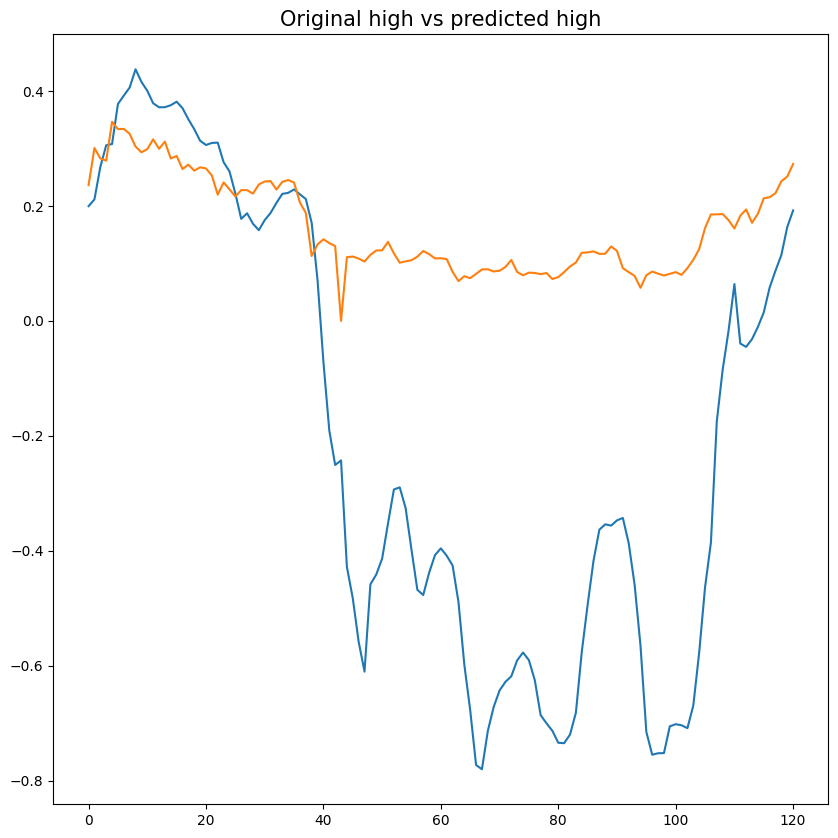

In [73]:
#testY=testY.reshape(-1,1)
plt.figure(figsize=(10, 10))
plt.plot(testPredict[0:testY.shape[0], 0], label=("Predicted High"))
plt.plot(testY[:, 0], label=("Actual High"))
plt.title('Original high vs predicted high', fontsize=15)
plt.show()

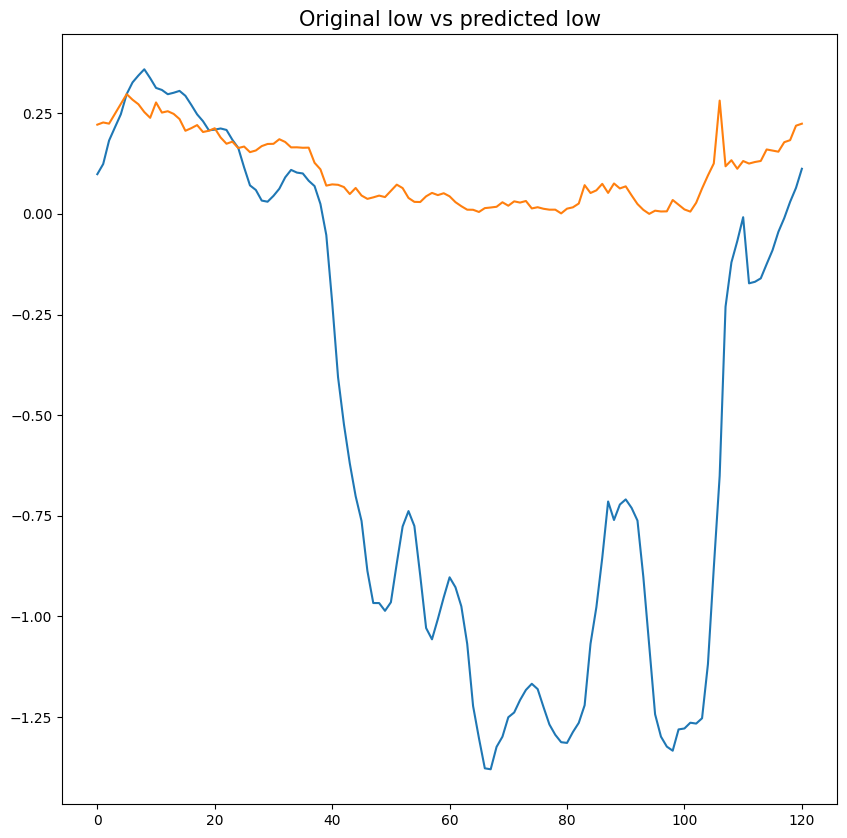

In [74]:
plt.figure(figsize=(10, 10))
plt.plot(testPredict[0:testY.shape[0], 1], label=("Predicted Low"))
plt.plot(testY[:, 1],label=("Actual Low"))
plt.title('Original low vs predicted low', fontsize=15)
plt.show()

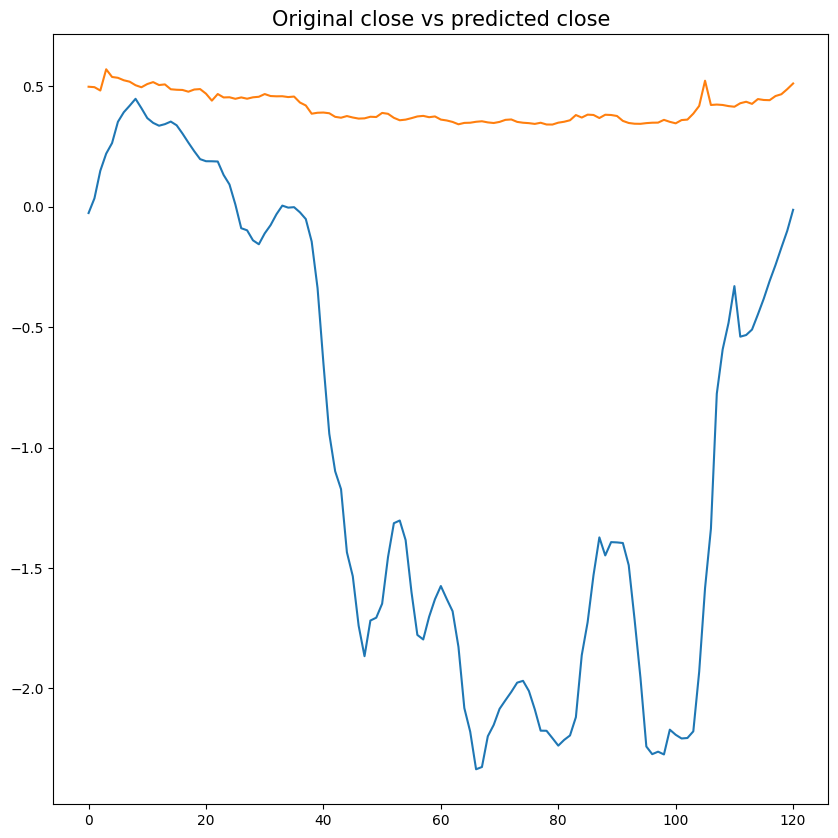

In [75]:
#testY=testY.reshape(-1,1)
plt.figure(figsize=(10, 10))
plt.plot(testPredict[0:testY.shape[0], 2], label=("Predicted Close"))
plt.plot(testY[:, 2], label=("Actual Close"))
plt.title('Original close vs predicted close', fontsize=15)
plt.show()